# PriorCVAE on Lotka Volterra

In [1]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
import flax.linen as nn

import numpyro
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)

import jax
import optax
from jax import random
import jax.numpy as jnp

from priorCVAE_copy.models import CNNEncoder, CNNDecoder, VAE
from priorCVAE_copy.datasets import LVDataset, LVDataset_Beta
from priorCVAE_copy.trainer import VAETrainer
from priorCVAE_copy.losses import SquaredSumAndKL, SumPixelAndKL

import pints_jax as pintsjax

import jax.config as config
config.update("jax_enable_x64", True)

## Generate Data-Uniform Prior on One Parameter
**Problem:** how can we get a general enough data set, including different initial population densities and parameters?   
Parameters are easier to generate, uniform priors will be fine. What about initial population densities? What are common initial circumstances for the Lotka Volterra model? What are considered as general?

In [2]:
generator = LVDataset()
time_train, xy_train, params_train = generator.simulatedata(10)
time_test, xy_test, params_test = generator.simulatedata(5000)

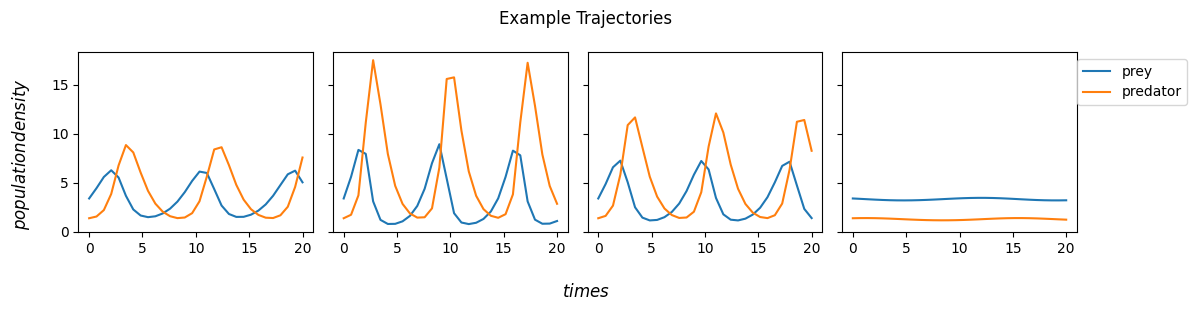

In [3]:
fig, axs = plt.subplots(1,4, sharex=True, sharey=True, figsize=(12,3))
for i in range(4):
    axs[i].plot(time_train[i], xy_train[i,:,0,:],label='prey')
    axs[i].plot(time_train[i], xy_train[i][:,1,:], label='predator')
plt.suptitle('Example Trajectories')
fig.supxlabel('$times$')
fig.supylabel('$population density$')
labels = ['prey', 'predator']
plt.legend(labels, loc='best', bbox_to_anchor=(1.5, 1))
plt.tight_layout()
plt.show()

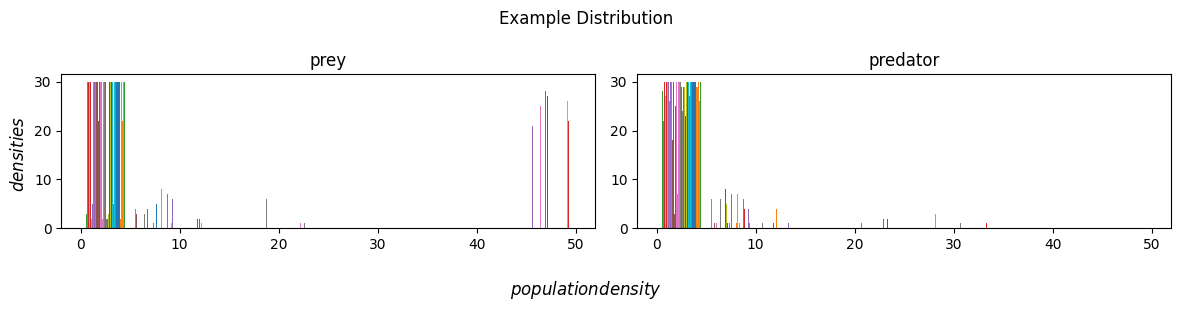

In [8]:
# Check the range of output values
fig, axs = plt.subplots(1,2,figsize=(12,3))
for i in range(2):
    axs[i].hist(xy_train[:,:,i,0])
    args = ['prey','predator']
    axs[i].set_title(args[i])
plt.suptitle('Example Distribution')
fig.supylabel('$densities$')
fig.supxlabel('$population density$')
plt.tight_layout()
plt.show()

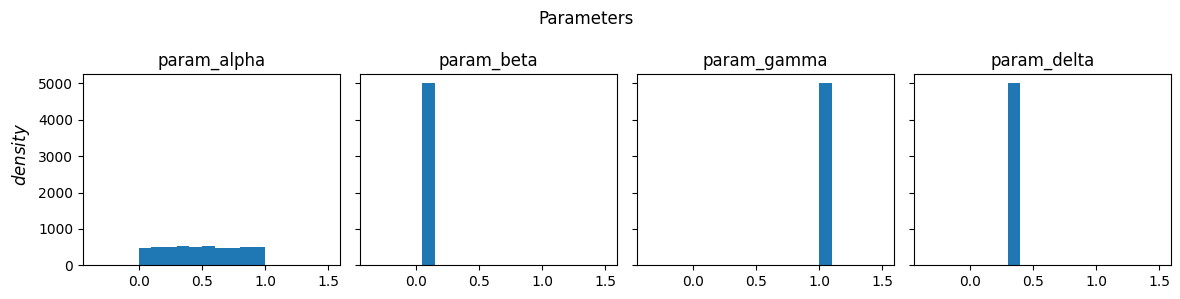

In [4]:
# Check the range of parameter values
fig, axs = plt.subplots(1,4, sharex=True, sharey=True, figsize=(12,3))
for i in range(4):
    axs[i].hist(params_test[:,i])
    args = ['param_alpha','param_beta','param_gamma','param_delta']
    axs[i].set_title(args[i])
plt.suptitle('Parameters')
fig.supylabel('$density$')
plt.tight_layout()
plt.show()

## PriorCVAE Model on One Parameter
Convolutional layer added with SumPixelAndKL loss.   
Five different test set is used, each of 2000 data. Model is trained on 500(batch size)*2000(iterations) = 1,000,000 data.

In [5]:
# Default setting: Valid Padding
# Trained with fixed initial value (log30, log4)
cnn_encoder = CNNEncoder(conv_features=[8,12], hidden_dim=10, latent_dim=8, conv_activation=nn.tanh, conv_kernel_size=[[4,1], [3,2]], conv_stride=[(2,1), (1,1)])
cnn_decoder = CNNDecoder(conv_features=[6,1], conv_kernel_size=[[3,2],[4,1]],hidden_dim=10, decoder_reshape=(12,1,8), out_channel=1, conv_stride=[(1,1),(2,1)], conv_activation=nn.tanh)
model = VAE(cnn_encoder, cnn_decoder)
optimizer= optax.adam(learning_rate=1e-3)

trainer = VAETrainer(model, optimizer, loss=SumPixelAndKL(conditional=True))

In [12]:
trainer.init_params(xy_train[0][jnp.newaxis,:,:,:],c=params_train[0][jnp.newaxis,:])
loss_1 = []
loss_2 = []
for i in range(5):
    time_test, xy_test, params_test = generator.simulatedata(2000)
    test_set = (time_test, xy_test, params_test)
    loss_vals, test_vals, time_taken = trainer.train(generator, test_set, 2000, 500)
    loss_1 = loss_1 + loss_vals
    loss_2 = loss_2 + test_vals

[    1] training loss: 297.527, test loss: 528.670
[   11] training loss: 229.712, test loss: 308.919
[   21] training loss: 201.869, test loss: 221.340
[   31] training loss: 189.198, test loss: 195.972
[   41] training loss: 182.252, test loss: 184.841
[   51] training loss: 172.132, test loss: 175.344
[   61] training loss: 160.768, test loss: 165.612
[   71] training loss: 152.696, test loss: 155.515
[   81] training loss: 143.545, test loss: 146.362
[   91] training loss: 136.078, test loss: 138.514
[  101] training loss: 132.096, test loss: 132.083
[  111] training loss: 129.484, test loss: 127.229
[  121] training loss: 123.809, test loss: 123.531
[  131] training loss: 117.680, test loss: 120.840
[  141] training loss: 116.642, test loss: 118.823
[  151] training loss: 114.693, test loss: 117.278
[  161] training loss: 115.600, test loss: 116.041
[  171] training loss: 116.281, test loss: 115.029
[  181] training loss: 114.753, test loss: 114.222
[  191] training loss: 114.001,

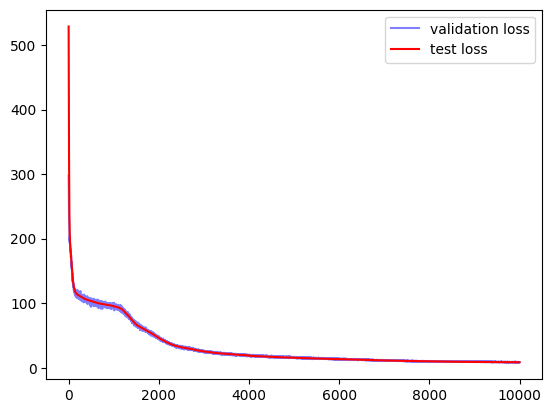

In [13]:
plt.plot(range(len(loss_1)), loss_1, color='blue', label='validation loss',alpha = 0.5,)
plt.plot(range(len(loss_2)),loss_2, color='red', label='test loss')
plt.legend()
plt.show()

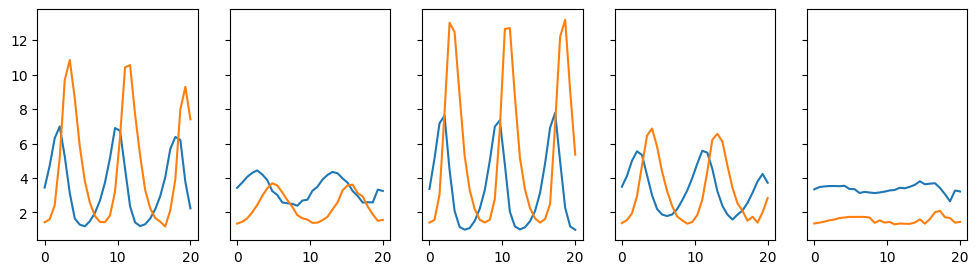

In [15]:
decoder_params = trainer.state.params['decoder']
key = jax.random.PRNGKey(rnd.randint(0, 9999))
z_rng, c_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (50, 8))
decoder = CNNDecoder(conv_features=[6,1], conv_kernel_size=[[3,2],[4,1]],hidden_dim=10, decoder_reshape=(12,1,8), out_channel=1, conv_stride=[(1,1),(2,1)], conv_activation=nn.tanh)

c = jax.random.uniform(c_rng, shape=(50,4))
c = c.at[:,1:].set([0.15,1,.3])
z_c = jnp.concatenate([z, c], axis=-1)
out = decoder.apply({'params': decoder_params}, z_c)             

fig, axs = plt.subplots(1,5, sharex=True, sharey=True, figsize=(12,3))
for i in range(5):
    axs[i].plot(time_train[i], out[i,:,0,:],label='prey')
    axs[i].plot(time_train[i], out[i][:,1,:], label='predator')

plt.show()

In [16]:
# Check performance for low end values.
model = pintsjax.toy.LotkaVolterraModel()
times = np.linspace(0,20,30)
params_1 = np.array([0.1,0.15,1,.3])
params_2 = np.array([0.2,0.15,1,.3])
values_1 = model.simulate(params_1, times)
values_2 = model.simulate(params_2, times)

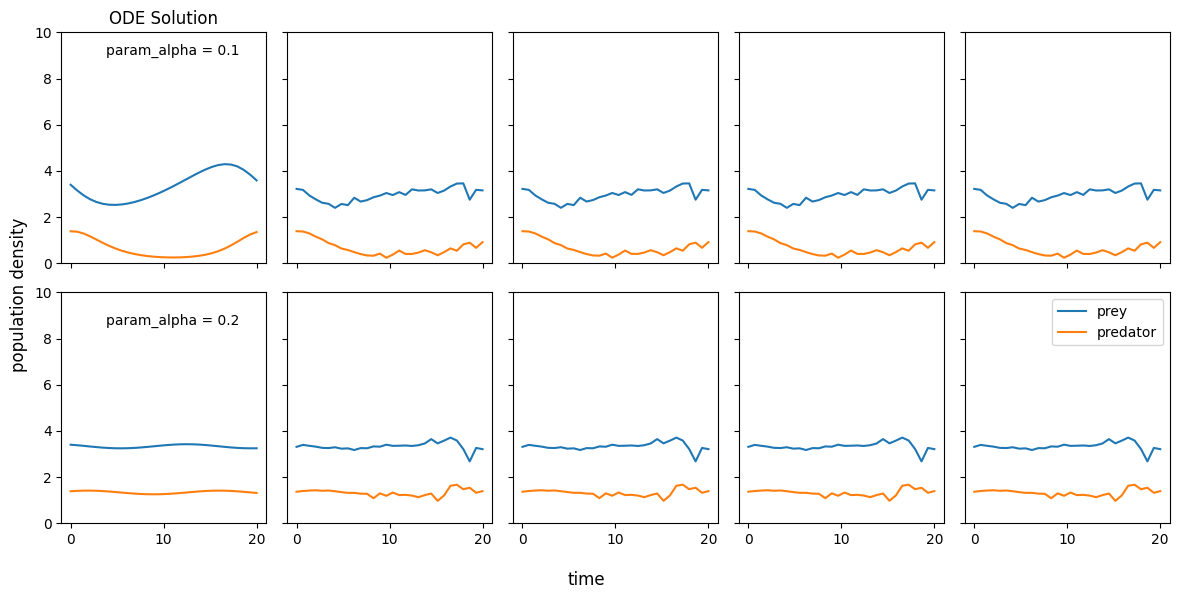

In [36]:
# Fixed parameter - expect the same results
decoder_params = trainer.state.params['decoder']
key = jax.random.PRNGKey(rnd.randint(0, 9999))
z_rng, c_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (10, 8))
decoder = CNNDecoder(conv_features=[6,1], conv_kernel_size=[[3,2],[4,1]],hidden_dim=10, decoder_reshape=(12,1,8), out_channel=1, conv_stride=[(1,1),(2,1)], conv_activation=nn.tanh)

c_1 = np.array([0.1,0.15,1,.3])
c_1 = jnp.tile(c_1, (10,1))
z_c_1 = jnp.concatenate([z, c_1], axis=-1)
out_1 = decoder.apply({'params': decoder_params}, z_c_1)       

c_2 = np.array([0.2,0.15,1,.3])
c_2 = jnp.tile(c_2, (10,1))
z_c_2 = jnp.concatenate([z, c_2], axis=-1)
out_2 = decoder.apply({'params': decoder_params}, z_c_2)      

fig, axs = plt.subplots(2,5, sharex=True, sharey=True, figsize=(12,6))
axs[0,0].plot(times, values_1[:,0], label = 'prey')
axs[0,0].plot(times, values_1[:,1], label = 'predator')
axs[0,0].title.set_text('ODE Solution')
axs[1,0].plot(times, values_2[:,0], label = 'prey')
axs[1,0].plot(times, values_2[:,1], label = 'predator')
for i in range(4):
    axs[0,i+1].plot(time_train[i], out_1[i,:,0,:],label='prey')
    axs[0,i+1].plot(time_train[i], out_1[i][:,1,:], label='predator')
    axs[1,i+1].plot(time_train[i], out_2[i,:,0,:],label='prey')
    axs[1,i+1].plot(time_train[i], out_2[i][:,1,:], label='predator')
plt.legend()
plt.figtext(0.1,0.9,'param_alpha = 0.1')
plt.figtext(0.1,0.45,'param_alpha = 0.2')
plt.ylim(0,10)
fig.supxlabel('time')
fig.supylabel('population density')
plt.tight_layout()
plt.show()

## Generate Data-Beta Prior on One Param

In [9]:
generator_b = LVDataset_Beta()
time_train_b, xy_train_b, params_train_b = generator_b.simulatedata(10)
time_test_b, xy_test_b, params_test_b = generator_b.simulatedata(5000)

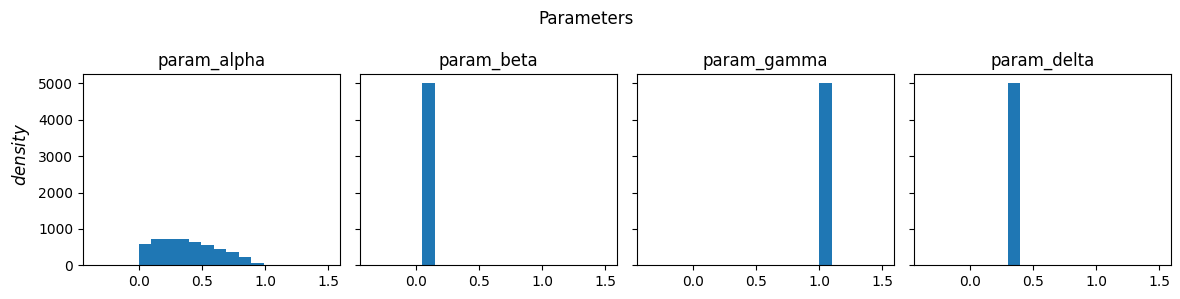

In [10]:
# Check the range of parameter values
fig, axs = plt.subplots(1,4, sharex=True, sharey=True, figsize=(12,3))
for i in range(4):
    axs[i].hist(params_test_b[:,i])
    args = ['param_alpha','param_beta','param_gamma','param_delta']
    axs[i].set_title(args[i])
plt.suptitle('Parameters')
fig.supylabel('$density$')
plt.tight_layout()
plt.show()

## PriorCVAE Model on One Parameter
Using the same configuration of CNN as before, the same model and optimizer.  

In [12]:
# Default setting: Valid Padding
# Trained with fixed initial value (log30, log4)
trainer_b = VAETrainer(model, optimizer, loss=SumPixelAndKL(conditional=True))

trainer_b.init_params(xy_train_b[0][jnp.newaxis,:,:,:],c=params_train_b[0][jnp.newaxis,:])
loss_1_b = []
loss_2_b = []
for i in range(5):
    time_test, xy_test, params_test = generator_b.simulatedata(2000)
    test_set = (time_test, xy_test, params_test)
    loss_vals, test_vals, time_taken = trainer_b.train(generator_b, test_set, 2000, 500)
    loss_1_b = loss_1_b + loss_vals
    loss_2_b = loss_2_b + test_vals

[    1] training loss: 294.375, test loss: 587.884
[   11] training loss: 212.984, test loss: 322.095
[   21] training loss: 172.244, test loss: 198.924
[   31] training loss: 153.362, test loss: 160.427
[   41] training loss: 143.800, test loss: 145.823
[   51] training loss: 134.166, test loss: 135.439
[   61] training loss: 125.360, test loss: 126.951
[   71] training loss: 114.221, test loss: 119.786
[   81] training loss: 111.152, test loss: 113.360
[   91] training loss: 105.747, test loss: 107.569
[  101] training loss: 99.914, test loss: 102.505
[  111] training loss: 97.185, test loss: 98.730
[  121] training loss: 92.943, test loss: 95.895
[  131] training loss: 94.799, test loss: 93.662
[  141] training loss: 87.612, test loss: 91.933
[  151] training loss: 90.539, test loss: 90.537
[  161] training loss: 87.680, test loss: 89.376
[  171] training loss: 86.372, test loss: 88.358
[  181] training loss: 84.391, test loss: 87.443
[  191] training loss: 85.121, test loss: 86.595

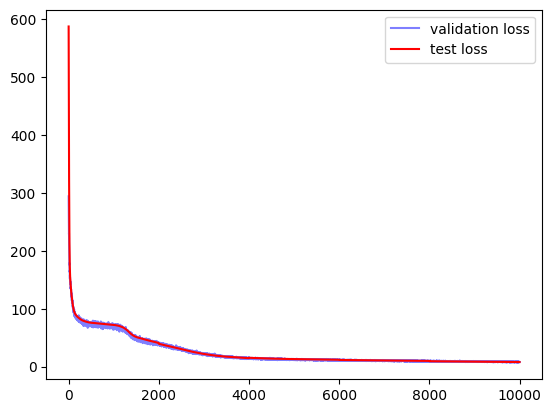

In [13]:
plt.plot(range(len(loss_1_b)), loss_1_b, color='blue', label='validation loss',alpha = 0.5,)
plt.plot(range(len(loss_2_b)),loss_2_b, color='red', label='test loss')
plt.legend()
plt.show()

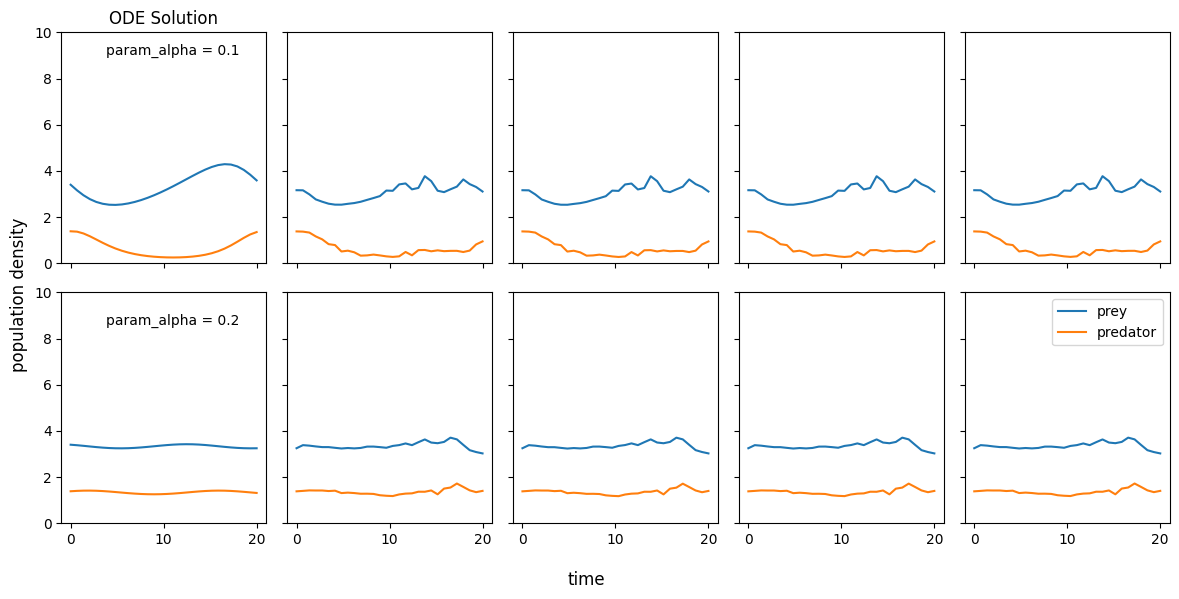

In [18]:
# Check performance of low end parameter values
# Fixed parameter - expect the same results
decoder_params = trainer_b.state.params['decoder']
key = jax.random.PRNGKey(rnd.randint(0, 9999))
z_rng, c_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (10, 8))
decoder = CNNDecoder(conv_features=[6,1], conv_kernel_size=[[3,2],[4,1]],hidden_dim=10, decoder_reshape=(12,1,8), out_channel=1, conv_stride=[(1,1),(2,1)], conv_activation=nn.tanh)

c_1 = np.array([0.1,0.15,1,.3])
c_1 = jnp.tile(c_1, (10,1))
z_c_1 = jnp.concatenate([z, c_1], axis=-1)
out_1 = decoder.apply({'params': decoder_params}, z_c_1)       

c_2 = np.array([0.2,0.15,1,.3])
c_2 = jnp.tile(c_2, (10,1))
z_c_2 = jnp.concatenate([z, c_2], axis=-1)
out_2 = decoder.apply({'params': decoder_params}, z_c_2)      

fig, axs = plt.subplots(2,5, sharex=True, sharey=True, figsize=(12,6))
axs[0,0].plot(times, values_1[:,0], label = 'prey')
axs[0,0].plot(times, values_1[:,1], label = 'predator')
axs[0,0].title.set_text('ODE Solution')
axs[1,0].plot(times, values_2[:,0], label = 'prey')
axs[1,0].plot(times, values_2[:,1], label = 'predator')
for i in range(4):
    axs[0,i+1].plot(time_train_b[i], out_1[i,:,0,:],label='prey')
    axs[0,i+1].plot(time_train_b[i], out_1[i][:,1,:], label='predator')
    axs[1,i+1].plot(time_train_b[i], out_2[i,:,0,:],label='prey')
    axs[1,i+1].plot(time_train_b[i], out_2[i][:,1,:], label='predator')
plt.legend()
plt.figtext(0.1,0.9,'param_alpha = 0.1')
plt.figtext(0.1,0.45,'param_alpha = 0.2')
plt.ylim(0,10)
fig.supxlabel('time')
fig.supylabel('population density')
plt.tight_layout()
plt.show()